In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import os

# Unipolar vs Bipolar: ALL

In [2]:
# model tuning parameters
n_splits = 5
criterion = 'accuracy'

In [3]:
df = pd.read_csv('../../data/final_dataset.csv')
df = df[df['Diagnosis'] != 'Control'] 

In [4]:
df['Diagnosis'].unique()

array(['Bipolar II', 'Major Depressive Disorder', 'Bipolar I', 'MDD'],
      dtype=object)

In [5]:
df['Group'] = df['Diagnosis']
df['Group'] = df['Group'].replace('Bipolar I',0)
df['Group'] = df['Group'].replace('Bipolar II',0)
df['Group'] = df['Group'].replace('MDD',1)
df['Group'] = df['Group'].replace('Major Depressive Disorder',1)
df.columns

Index(['Unnamed: 0', 'Watch Status', 'Phone Brand', 'Diagnosis', 'Gender',
       'Study ID', 'LAMP ID', 'Race', 'Age', 'DOB', 'Date of Consent',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'screen_duration_mean',
       'screen_duration_var', 'internal_sleep_mean', 'internal_sleep_var',
       'PHQ-2_mean', 'PHQ-2_var', 'GAD-2_mean', 'GAD-2_var', 'Group'],
      dtype='object')

In [6]:
yes = df[df['Group']==1]

In [7]:
# predictor and target vars
X = df[['gps_data_quality_mean', 'gps_data_quality_var', 'GAD-2_mean', 'GAD-2_var', 'GAD-2_mean', 'PHQ-2_var',
  'hometime_mean', 'hometime_var', 'entropy_mean',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var', 'screen_duration_mean',
     'screen_duration_var']]
y = df['Group']

In [8]:
pct_imputed = (X.isnull().sum().sum())/(np.shape(X)[0]*np.shape(X)[1])
print("We have imputed %0.1f percent of the data" % (pct_imputed * 100))

We have imputed 14.2 percent of the data


In [9]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=0)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [10]:
# standardize
scale_train = StandardScaler()
scale_test = StandardScaler()

X_train = scale_train.fit_transform(X_train)
X_test = scale_test.fit_transform(X_test)

In [11]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [12]:
accuracy, precision, recall, auc = {}, {}, {}, {}

for key in models.keys():
    print(key)
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score(y_test, predictions)
    auc[key] = roc_auc_score(y_test, predictions)

Logistic Regression
Support Vector Machines
Decision Trees
Random Forest
Naive Bayes
K-Nearest Neighbor


In [13]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['AUC'] = auc.values()

In [14]:
df_model

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.607143,0.684211,0.722222,0.561111
Support Vector Machines,0.607143,0.684211,0.722222,0.561111
Decision Trees,0.571429,0.687500,0.611111,0.555556
Random Forest,0.500000,0.590909,0.722222,0.411111
Naive Bayes,0.500000,0.642857,0.500000,0.500000
K-Nearest Neighbor,0.642857,0.666667,0.888889,0.544444


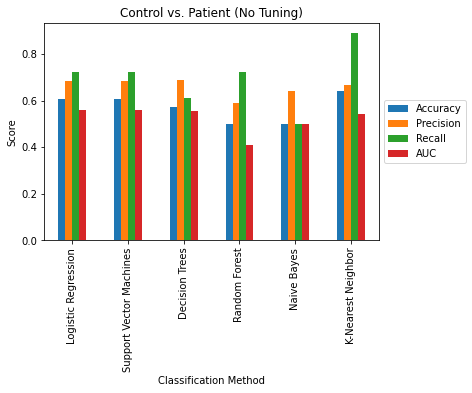

In [15]:
df_model.plot(kind="bar")
plt.title("Control vs. Patient (No Tuning)")
plt.xlabel("Classification Method")
plt.ylabel("Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [16]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train);
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
params = grid_search.best_params_

Best: 0.666667 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.480000 (0.170316) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.480000 (0.170316) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.468889 (0.174044) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.555556 (0.222999) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.555556 (0.222999) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.568889 (0.231090) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.593333 (0.241354) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.593333 (0.241354) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.555556 (0.257241) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.631111 (0.110532) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.631111 (0.110532) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.566667 (0.250037) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.666667 (0.073030) wi

In [17]:
# instantiate the model (using tuned params)
logreg_tuned = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'])

# fit the model with data
logreg_tuned.fit(X_train, y_train)

y_pred = logreg_tuned.predict(X_test)

In [18]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 0, 10],
       [ 0, 18]])

Text(0.5, 257.44, 'Predicted label')

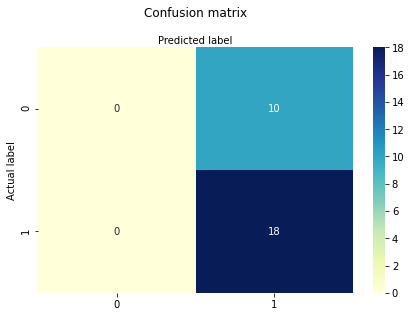

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [20]:
print(f'Logistic Regression Model Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Logistic Regression Model Acccuracy (Tuned Using Optimal Params): 0.6428571428571429


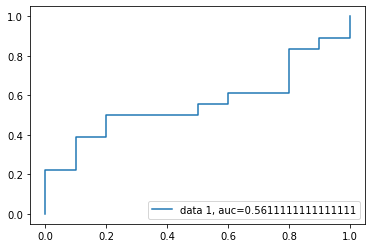

In [21]:
y_pred_proba = logreg_tuned.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Support Vector Machines

In [22]:
# define model and parameters
model = LinearSVC()
penalty = ['l2']
loss=['squared_hinge']
dual=[True, False]
C = [10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty, loss=loss, dual=dual, C=C)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.591111 using {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.480000 (0.185313) with: {'C': 10, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.480000 (0.170316) with: {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.520000 (0.228943) with: {'C': 1.0, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.520000 (0.228943) with: {'C': 1.0, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.591111 (0.243574) with: {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.591111 (0.243574) with: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.566667 (0.250037) with: {'C': 0.01, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.566667 (0.250037) with: {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [23]:
params = grid_search.best_params_

In [24]:
linSVC_tuned = LinearSVC(C=params['C'], dual=params['dual'], loss=params['loss'])

In [25]:
# fit the model with data
linSVC_tuned.fit(X_train, y_train)

y_pred = linSVC_tuned.predict(X_test)

In [26]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 4,  6],
       [ 6, 12]])

In [27]:
print(f'Linear SVM Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Linear SVM Acccuracy (Tuned Using Optimal Params): 0.5714285714285714


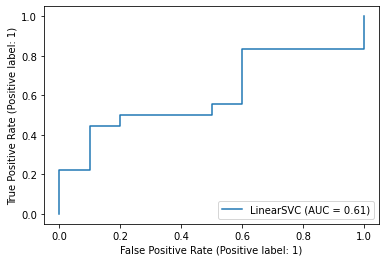

In [28]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(linSVC_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

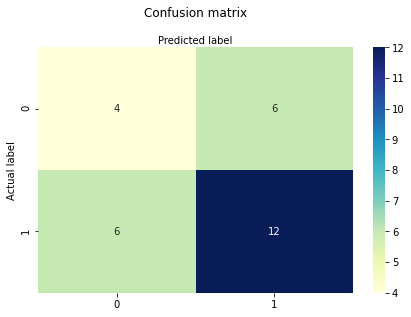

In [29]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



## Decision Trees

In [30]:
model = DecisionTreeClassifier()
splitter = ['best', 'random']
min_samples_split = range(1, 5) #41
min_samples_leaf = range(1, 5) #21
max_features = [None, 'auto', 'sqrt', 'log2']
presort = [True, False]
# define grid search
grid = dict(splitter=splitter, min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf,
            max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.664444 using {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'best'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'random'}
0.595556 (0.154856) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.553333 (0.224037) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
0.546667 (0.142361) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
0.500000 (0.165999) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
0.522222 (0.128043) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
0.468889 (0.231730) with: {'max_features': None, 'min_samples_leaf'

In [31]:
stds[np.argmax(means)]

0.23834822538296754

In [32]:
max(means)

0.6644444444444443

In [33]:
np.argmax(means)

39

In [34]:
params = grid_search.best_params_

In [35]:
# instantiate the model (using tuned params)
decTree_tuned = DecisionTreeClassifier(max_features=params['max_features'], 
                                       min_samples_leaf=params['min_samples_leaf'], 
                                       min_samples_split=params['min_samples_split'],
                                      splitter=params['splitter'])



# fit the model with data
decTree_tuned.fit(X_train, y_train)

y_pred = decTree_tuned.predict(X_test)
y_pred_proba = decTree_tuned.predict_proba(X_test)

In [36]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 2,  8],
       [ 6, 12]])

In [37]:
print(f'Decision Trees Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Decision Trees Acccuracy (Tuned Using Optimal Params): 0.5


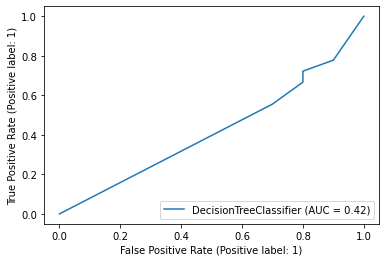

In [38]:
plot_roc_curve(decTree_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

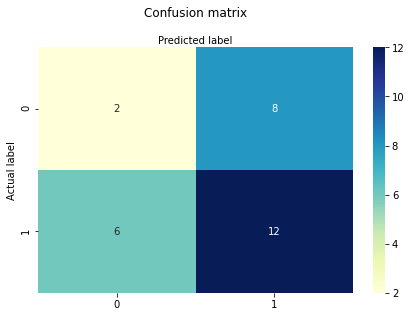

In [39]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Random Forest

In [ ]:
model = RandomForestClassifier()

max_depth= [80, 90, 100, 110]
max_features = [2, 3]
min_samples_leaf = [3, 4, 5]
min_samples_split = [8, 10, 12]
n_estimators = [100, 200, 300, 1000]
# define grid search
grid = dict(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
           min_samples_split=min_samples_split, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
params = grid_search.best_params_


In [ ]:
# instantiate the model (using tuned params)
ranForest_tuned = RandomForestClassifier(max_features=params['max_features'],
                                         min_samples_leaf=params['min_samples_leaf'], 
                                         min_samples_split=params['min_samples_split'],
                                     max_depth=params['max_depth'], n_estimators=params['n_estimators'])

# fit the model with data
ranForest_tuned.fit(X_train, y_train)

y_pred = ranForest_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print(f'Random Forest Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [ ]:
from sklearn.metrics import plot_roc_curve


plot_roc_curve(ranForest_tuned,X_test,y_test)

## Naive Bayes

In [ ]:
model = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, param_grid=params_NB, cv=cv, scoring=criterion, error_score=0)
grid_result = grid_search.fit(X_train, y_train);
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
params = grid_search.best_params_

In [ ]:
nb_tuned = GaussianNB(var_smoothing =  params['var_smoothing'])
# fit the model with data
nb_tuned.fit(X_train, y_train)

y_pred = nb_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print(f'Gaussian Naive Bayes Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [ ]:
plot_roc_curve(nb_tuned,X_test,y_test)

## KNN Classifier

In [ ]:
model = KNeighborsClassifier()

leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]

# define grid search
grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train);
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
params = grid_search.best_params_

In [ ]:
knn_tuned = KNeighborsClassifier(leaf_size=params['leaf_size'], 
                                 n_neighbors=params['n_neighbors'], 
                                p=params['p'])
# fit the model with data
knn_tuned.fit(X_train, y_train)

y_pred = knn_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print(f'KNN Classifier Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [ ]:
plot_roc_curve(knn_tuned,X_test,y_test)